Based on:
https://github.com/melanieshi0120/COVID-19_global_time_series_panel_data/blob/master/Time_series_panel_data_model_part_fatality.ipynb

# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, r2_score, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = os.path.join(os.getcwd(), 'data')

datasets = []

for file in os.listdir(data_path):
    key = os.path.splitext(file)[0]
    globals()[key] = pd.read_csv(os.path.join(data_path, file))
    datasets.append(globals()[key])

# Datasets

## `n2k` (need to know)

In [3]:
n2k_data

,track,traction,track_evolution,braking,asphalt_grip,lateral,asphalt_abrasion,tyre_stress,downforce,c1_compound,...,laps,race_dist,circuit_length,turns,elevation_change,top_speed,tyre_camber_lim_front,tyre_camber_lim_rear,min_starting_press_front,min_starting_press_rear
0,Bahrain,4.0,4.0,4.0,3.0,3.0,5.0,3.0,3.0,1,...,57,308.238,5.412,15,16.800,327.9,-3.50,-2.00,21.0,18.5
1,Saudi Arabia,2.0,4.0,2.0,3.0,3.0,2.0,3.0,2.0,0,...,50,308.450,6.174,27,2.480,334.6,-3.25,-1.75,22.5,21.0
2,Australia,2.0,4.0,2.0,3.0,3.0,2.0,3.0,3.0,0,...,58,306.124,5.278,14,2.440,326.2,-3.25,-1.75,23.0,21.0
3,Azerbaijan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,51,306.153,6.003,20,26.960,351.8,NaN,NaN,NaN,NaN
4,Miami,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,57,308.484,5.412,19,3.530,349.3,NaN,NaN,NaN,NaN
5,Monaco,5.0,5.0,2.0,1.0,1.0,1.0,1.0,5.0,0,...,78,260.286,3.337,19,41.950,289.0,-3.50,-2.50,21.0,19.5
6,Spain,3.0,3.0,3.0,3.0,5.0,4.0,5.0,4.0,1,...,66,307.236,4.657,14,29.630,307.2,-3.25,-1.75,23.0,20.0
7,Canada,5.0,5.0,5.0,1.0,1.0,2.0,3.0,1.0,0,...,70,305.270,4.361,14,5.250,342.7,-3.25,-2.00,22.0,20.5
8,Austria,2.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,0,...,71,306.452,4.318,10,63.400,324.7,-3.25,-1.75,23.0,20.0
9,Great Britain,3.0,2.0,2.0,3.0,5.0,3.0,5.0,4.0,1,...,52,306.198,5.891,18,11.310,332.6,-2.75,-1.50,26.5,23.0


In [4]:
circuits_map = {
    'Bahrain': 'bahrain',
    'Saudi Arabia': 'jeddah',
    'Australia': 'albert_park',
    'Azerbaijan': 'baku',
    'Miami': 'miami',
    'Monaco': 'monaco',
    'Spain': 'catalunya',
    'Canada': 'villeneuve',
    'Austria': 'red_bull_ring',
    'Great Britain': 'silverstone',
    'Hungary': 'hungaroring',
    'Belgium': 'spa',
    'Netherlands': 'zandvoort',
    'Italy': 'monza',
    'Singapore': 'marina_bay',
    'Japan': 'suzuka',
    'United States': 'americas',
    'Mexico': 'rodriguez',
    'Brazil': 'interlagos',
    'Abu Dhabi': 'yas_marina',
}

In [5]:
n2k_data['circuitRef'] = n2k_data['track'].map(circuits_map)
n2k_data.drop(columns=['track'], inplace=True)

## `results`

In [6]:
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3,19,16,16,16,0.0,44,+1:43.071,5053521,25,15,1:50.994,227.169,1
26076,26082,1110,858,3,2,18,17,17,17,0.0,44,+1:44.476,5054926,37,9,1:50.486,228.213,1
26077,26083,1110,807,210,27,0,18,18,18,0.0,44,+1:50.450,5060900,26,4,1:49.907,229.415,1
26078,26084,1110,832,6,55,4,\N,R,19,0.0,23,\N,\N,9,19,1:53.138,222.864,130


- Maintain Id columns to merge than remove them
- `number` not necessary (idea: transform to binary previousChampion based on if the number is 1)
- in `grid` value 0 means started from pitlane (?)
- `position` and `positionText` show the same information, and `positionOrder` has a slightly difference (idea: two variables - `positionOrder` & binary about the retirements)
- `time` and `milliseconds` show the same information
- `rank`, `fastestLapTime` & `fastestLapSpeed` show the same information

## `driver_standings`

In [7]:
driver_standings

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0
...,...,...,...,...,...,...,...
34119,72183,1110,846,69.0,8,8,0
34120,72184,1110,839,35.0,10,10,0
34121,72185,1110,844,99.0,5,5,0
34122,72186,1110,857,34.0,11,11,0


- `position` and `positionText` have the same information

## `constructor_results`

In [8]:
constructor_results

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N
...,...,...,...,...,...
12285,16785,1110,214,10.0,\N
12286,16786,1110,213,1.0,\N
12287,16787,1110,51,0.0,\N
12288,16788,1110,3,0.0,\N


In [9]:
constructor_results[~(constructor_results['status'] == '\\N')]

,constructorResultsId,raceId,constructorId,points,status
185,186,36,1,14.0,D
195,196,37,1,18.0,D
207,208,38,1,12.0,D
218,219,39,1,14.0,D
228,229,40,1,18.0,D
239,240,41,1,12.0,D
250,251,42,1,18.0,D
262,263,43,1,8.0,D
273,274,44,1,14.0,D
283,284,45,1,10.0,D


- `status` is almost only missing values

## `constructor_standings`

In [10]:
constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0
...,...,...,...,...,...,...,...
13046,28568,1110,214,57.0,6,6,0
13047,28569,1110,3,11.0,7,7,0
13048,28570,1110,213,3.0,10,10,0
13049,28571,1110,210,11.0,8,8,0


- `position` and `positionText` have the same information

## `races`

In [11]:
races

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1097,1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1098,1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1099,1119,2023,21,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


- `name` not necessary
- extract month from `date` (day probably not necessary)
- `time` in +12 GMT do not say very much (idea: try to transform it into local time)
- last group of variables have to be evaluated

## `circuits`

In [12]:
circuits

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park
...,...,...,...,...,...,...,...,...,...
72,75,portimao,Autódromo Internacional do Algarve,Portimão,Portugal,37.22700,-8.62670,108,http://en.wikipedia.org/wiki/Algarve_Internati...
73,76,mugello,Autodromo Internazionale del Mugello,Mugello,Italy,43.99750,11.37190,255,http://en.wikipedia.org/wiki/Mugello_Circuit
74,77,jeddah,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.63190,39.10440,15,http://en.wikipedia.org/wiki/Jeddah_Street_Cir...
75,78,losail,Losail International Circuit,Al Daayen,Qatar,25.49000,51.45420,\N,http://en.wikipedia.org/wiki/Losail_Internatio...


- `circuitRef` probably better than `name`
- `circuitRef` is very similar with `location`

## `drivers`

In [13]:
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese,http://en.wikipedia.org/wiki/Zhou_Guanyu
854,856,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri


- `driverRef` better than `code`, `forename` and `surname`
- `number` not necessary
- `dob` convert it into the age of the driver in the day of the race

## `constructors`

In [14]:
constructors

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...,...
206,209,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport
207,210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
208,211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
209,213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri


- `constructorRef` better than `name`

## `status`

In [15]:
status

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


## `qualifying`

In [16]:
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9810,9868,1110,848,3,23,16,2:00.314,\N,\N
9811,9869,1110,855,51,24,17,2:00.832,\N,\N
9812,9870,1110,858,3,2,18,2:01.535,\N,\N
9813,9871,1110,817,213,3,19,2:02.159,\N,\N


- `number` not necessary
- there are obviously many missing values in `q2` and `q3` idea

## `lap_times`

In [17]:
lap_times

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
...,...,...,...,...,...,...
551737,1110,817,40,17,1:54.361,114361
551738,1110,817,41,17,1:53.367,113367
551739,1110,817,42,16,1:55.247,115247
551740,1110,817,43,16,1:52.115,112115


In [18]:
lap_times_2 = pd.merge(lap_times, races, on='raceId', how='left')
lap_times_3 = pd.merge(lap_times_2, drivers, on='driverId', how='left')
lap_times_4 = pd.merge(lap_times_3, circuits, on='circuitId', how='left')
lap_times_table = lap_times_4[['lap', 'position', 'milliseconds', 'year', 'driverRef', 'circuitRef']]

## `pit_stops`

In [19]:
pit_stops

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842
...,...,...,...,...,...,...,...
10084,1110,4,2,29,15:59:01,23.798,23798
10085,1110,830,2,30,16:00:16,23.012,23012
10086,1110,848,3,33,16:07:06,23.529,23529
10087,1110,858,3,34,16:09:09,23.109,23109


## `sprint_results`

In [20]:
sprint_results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,1110,858,3,2,13,16,16,16,0,11,+37.571,1536004,6,2:03.482,1
176,177,1110,807,210,27,20,17,17,17,0,11,+37.827,1536260,6,2:03.472,1
177,178,1110,852,213,22,16,18,18,18,0,11,+39.267,1537700,7,2:02.080,1
178,179,1110,815,9,11,8,\N,R,19,0,8,\N,\N,2,2:02.516,130


# Merging

In [21]:
driver_standings

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0
...,...,...,...,...,...,...,...
34119,72183,1110,846,69.0,8,8,0
34120,72184,1110,839,35.0,10,10,0
34121,72185,1110,844,99.0,5,5,0
34122,72186,1110,857,34.0,11,11,0


In [22]:
merged_data1 = pd.merge(results, races, on='raceId', suffixes=('', 'Race'), how='left')
merged_data2 = pd.merge(merged_data1, qualifying, on=['raceId', 'driverId'], suffixes=('', 'Qualifying'), how='left')
merged_data3 = pd.merge(merged_data2, sprint_results, on=['raceId', 'driverId'], suffixes=('', 'Sprint'), how='left')
merged_data4 = pd.merge(merged_data3, drivers, on='driverId', how='left', suffixes=('', 'Driver'))
merged_data5 = pd.merge(merged_data4, constructors, on='constructorId', suffixes=('Driver', 'Constructor'), how='left')
merged_data6 = pd.merge(merged_data5, status, on='statusId', how='left')
merged_data7 = pd.merge(merged_data6, circuits, on='circuitId', how='left', suffixes=('', 'Circuit'))
merged_data8 = pd.merge(merged_data7, driver_standings, on=['raceId', 'driverId'], suffixes=('', 'DriverStandings'), how='left')
merged_data9 = pd.merge(merged_data8, constructor_standings, on=['raceId', 'constructorId'], suffixes=('', 'ConstructorStandings'), how='left')
merged_data10 = pd.merge(merged_data9, n2k_data, on='circuitRef', suffixes=('', 'Total'), how='left')
merged_data = merged_data10

In [23]:
merged_data.drop(columns=merged_data.filter(regex='Id').columns, inplace=True) #|number|url|name|fp|quali|sprint

In [24]:
data2223 = merged_data[merged_data['year'].isin([2022, 2023])]

In [25]:
# data2223.to_csv('data2223.csv', index=False)

# Missing Values

In [26]:
data2223.replace('\\N', np.nan, inplace=True)

In [27]:
def convert_to_float(var):
    try:
        return float(var)
    except (ValueError, TypeError):
        return var  # Return the variable itself if it can't be converted


for col in data2223.columns:
    data2223[col] = data2223[col].apply(convert_to_float)

## `alt`

In [28]:
data2223['alt'].fillna(7, inplace=True)
# https://www.freemaptools.com/elevation-finder.htm

## `fastestLap`, `fastestLapTime` & `lastestLapSpeed`

In [29]:
# def convert_to_milliseconds(time_str):
#     if pd.isnull(time_str):  # Check for 'nan'
#         return np.nan  # Return 'nan' value
    
#     minutes, seconds = map(float, str(time_str).split(':'))
#     total_seconds = (minutes * 60) + seconds
#     milliseconds = total_seconds * 1000
#     return milliseconds

# data2223['fastestLapTime'] = data2223['fastestLapTime'].apply(convert_to_milliseconds)

In [30]:
# fastestLapTimeMissing = pd.merge(lap_times_table,
#                                  data2223[(data2223['fastestLap'].isna()) & (data2223['laps'] != 0)][
#                                      ['year', 'driverRef', 'circuitRef']],
#                                  on=['year', 'driverRef', 'circuitRef'])

# fastestLapTimeMissing = fastestLapTimeMissing.groupby(['year', 'driverRef', 'circuitRef']).max()

In [31]:
# data2223 = pd.merge(data2223, fastestLapTimeMissing, 
#                     on=['year', 'driverRef', 'circuitRef'], how='left', suffixes=('', '_y'))

# data2223['fastestLap'].fillna(data2223['lap'], inplace=True)
# data2223['fastestLapTime'].fillna(data2223['milliseconds_y'], inplace=True)

# data2223.drop(['lap', 'position', 'milliseconds_y'], axis=1, inplace=True)

In [32]:
# slowestLapSpeed = data2223.groupby('date')['fastestLapSpeed'].min()
# fastestLapSpeedStd = data2223.groupby('date')['fastestLapSpeed'].std()

In [33]:
# data2223 = pd.merge(data2223, slowestLapSpeed, on='date', how='left', suffixes=('', 'Y'))
# data2223 = pd.merge(data2223, fastestLapSpeedStd, on='date', how='left', suffixes=('', '_y'))

In [34]:
# data2223['fastestLapSpeedToImpute'] = data2223['fastestLapSpeedY'] - round(data2223['fastestLapSpeed_y'], 3)
# data2223['fastestLapSpeed'].fillna(data2223['fastestLapSpeedToImpute'], inplace=True)
# data2223.drop(['fastestLapSpeedY', 'fastestLapSpeed_y', 'fastestLapSpeedToImpute'], axis=1, inplace=True)

In [35]:
# data2223 = pd.merge(data2223, lap_times_table[lap_times_table['lap'] == 1].groupby(['year', 'circuitRef'])['milliseconds'].max(),
#                     on=['year', 'circuitRef'], how='left', suffixes=('', '_y'))

In [36]:
# data2223['fastestLapTime'].fillna(data2223['milliseconds'], inplace=True)
# data2223['fastestLap'].fillna(1, inplace=True)
# data2223.drop('milliseconds_y', axis=1, inplace=True)

## `milliseconds`

In [37]:
# lastFinisherTime = data2223.groupby('date')['milliseconds'].max()

In [38]:
# data2223 = pd.merge(
#     data2223,
#     lastFinisherTime,
#     on=['date'],
#     suffixes=('', 'LastFinisher'),
#     how='left'
# )

In [39]:
# def calculate_missing_milliseconds(row):
#     if pd.isnull(row['milliseconds']):
#         laps_missing = 0
#         if '+1 Lap' in row['status']:
#             laps_missing = 1
#         elif '+2 Laps' in row['status']:
#             laps_missing = 2
#         elif '+6 Laps' in row['status']:
#             laps_missing = 6
#         elif row['status'] != 'Finished':
#             laps_missing = 10
        
#         if laps_missing > 0:
#             return row['millisecondsLastFinisher'] + laps_missing * row['fastestLapTime']
    
#     return row['milliseconds']

# # Apply the function to fill missing milliseconds
# data2223['milliseconds'] = data2223.apply(calculate_missing_milliseconds, axis=1)
# data2223.drop(columns=['millisecondsLastFinisher'], inplace=True)

# Feature Transformation/Engineering

## `age`

In [40]:
data2223['date'] = pd.to_datetime(data2223['date'])
data2223['dob'] = pd.to_datetime(data2223['dob'])

# data2223['month'] = data2223['date'].dt.month

# Calculate age by subtracting 'dob' from 'date'
data2223['age'] = (data2223['date'] - data2223['dob']).dt.days // 365

# Display the DataFrame with the new 'age' variable
data2223[['driverRef', 'dob', 'date', 'age']]

,driverRef,dob,date,age
25400,leclerc,1997-10-16,2022-03-20,24
25401,sainz,1994-09-01,2022-03-20,27
25402,hamilton,1985-01-07,2022-03-20,37
25403,russell,1998-02-15,2022-03-20,24
25404,kevin_magnussen,1992-10-05,2022-03-20,29
...,...,...,...,...
26075,ricciardo,1989-07-01,2023-07-30,34
26076,sargeant,2000-12-31,2023-07-30,22
26077,hulkenberg,1987-08-19,2023-07-30,35
26078,sainz,1994-09-01,2023-07-30,28


In [41]:
# data2223.drop(columns=['dob', 'timeRace', 'date'], inplace=True)

In [42]:
# # Function to map values
# def categorize_status(value):
#     if value == 'Finished':
#         return 'Finished'
#     elif  re.match(r'\+\d+ Laps?', value):
#         return 'Lapped'
#     elif value in ['Accident', 'Collision', 'Collision damage']:
#         return 'Accident'
#     else:
#         return 'Car issue'

# # Apply mapping function to 'status' column
# data2223['status'] = data2223['status'].apply(categorize_status)

## `nationality`

In [43]:
def nationality_to_binary(value):
    if value in ['American', 'Australian', 'Canadian', 'Chinese', 'Japanese', 'Mexican', 'Thai']:
        return 0
    else:
        return 1

data2223['nationalityDriver'] = data2223['nationalityDriver'].apply(nationality_to_binary)
data2223['nationalityConstructor'] = data2223['nationalityConstructor'].apply(nationality_to_binary)

## `firstDriver`

In [44]:
def first_driver(driver):
    first_drivers_list = ['max_verstappen',
                     'leclerc',
                     'hamilton',
                     'ocon',
                     'norris',
                     'bottas',
                     'stroll',
                     'kevin_magnussen',
                     'tsunoda', 
                     'albon'
                     ]

    if driver in first_drivers_list:
        return 1
    else:
        return 0
    
data2223['firstDriver'] = data2223['driverRef'].apply(first_driver)

## `standings`

In [45]:
data2223.sort_values(by=['year', 'round', 'constructorRef', 'firstDriver'], inplace=True)

In [46]:
# Shifting the last 5 columns by 20 observations
columns_to_shift = ['pointsDriverStandings', 'positionDriverStandings', 'wins', 'pointsConstructorStandings', 'positionConstructorStandings']

for col in columns_to_shift:
    data2223[col] = data2223[col].shift(20)

In [47]:
data2223.loc[
    (data2223['year'] == 2023) & (data2223['round'] == 1),
    ['pointsDriverStandings', 'positionDriverStandings', 'wins', 'pointsConstructorStandings', 'positionConstructorStandings']
    ] = np.nan

# Drop unnecessary columns for prediction

In [48]:
# Drop with regex
data2223.drop(columns=merged_data.filter(regex='url|fp|quali|sprint|Sprint|time|Text').columns, inplace=True)
# data2223.drop(columns=merged_data.filter(regex='number|url|name|fp|quali|sprint|Sprint|time|Text').columns, inplace=True)

# Drop datetime columns
data2223.drop(columns=data2223.select_dtypes(include='datetime').columns, inplace=True)

# Drop live features
live_columns = ['points', 'laps', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'status']
data2223.drop(columns=live_columns, inplace=True)

# Drop other columns
data2223.drop(columns=['position', 'q1', 'q2', 'q3', 'code'], inplace=True)

In [49]:
data2223.to_csv('data2223.csv', index=False)

: 

# Data Preparation

In [49]:
# DATA TYPES
def datatype_distinction(data):
    '''
    Distinguishes between the numerical and categorical columns in a DataFrame.

    Parameters:
    -----------
    data : pandas.DataFrame
        The input DataFrame.

    Returns:
    --------
    numerical : pandas.DataFrame
        DataFrame containing only numerical columns.

    categorical : pandas.DataFrame
        DataFrame containing only categorical columns.
    '''
    # Select numerical columns using select_dtypes with np.number
    numerical = data.select_dtypes(include=np.number).copy()
    
    # Select categorical columns by excluding numerical types
    categorical = data.select_dtypes(exclude=np.number).copy()
    
    return numerical, categorical


# DATA TRANSFORMATION
def transformation(technique, data, column_transformer=False):
    '''
    Applies the specified transformation technique to the DataFrame.

    Parameters:
    -----------
    technique : object
        The transformation technique (e.g., from Scikit-learn) to be applied.

    data : pandas.DataFrame
        The input DataFrame to be transformed.

    column_transformer : bool, optional (default=False)
        Flag to indicate if a column transformer is used for custom column names.

    Returns:
    --------
    data_transformed : pandas.DataFrame
        Transformed DataFrame.

    Notes:
    ------
    - If column_transformer is False, the columns in the transformed DataFrame
      will retain the original column names.
    - If column_transformer is True, the method assumes that technique has a
      get_feature_names_out() method and uses it to get feature names for the
      transformed data, otherwise retains the original column names.
    '''
    # Apply the specified transformation technique to the data
    data_transformed = technique.transform(data)
    
    # Create a DataFrame from the transformed data
    data_transformed = pd.DataFrame(
        data_transformed,
        index=data.index,
        columns=technique.get_feature_names_out() if column_transformer else data.columns
    )
    
    return data_transformed


def data_transform(technique, X_train, X_val=None, column_transformer=False):
    '''
    Fits a data transformation technique on the training data and applies the transformation 
    to both the training and validation data.

    Parameters:
    -----------
    technique : object
        The data transformation technique (e.g., from Scikit-learn) to be applied.

    X_train : pandas.DataFrame or array-like
        The training data to fit the transformation technique and transform.

    X_val : pandas.DataFrame or array-like, optional (default=None)
        The validation data to be transformed.

    column_transformer : bool, optional (default=False)
        Flag to indicate if a column transformer is used for custom column names.

    Returns:
    --------
    X_train_transformed : pandas.DataFrame
        Transformed training data.

    X_val_transformed : pandas.DataFrame or None
        Transformed validation data. None if X_val is None.

    Notes:
    ------
    - Fits the transformation technique on the training data (X_train).
    - Applies the fitted transformation to X_train and optionally to X_val if provided.
    '''
    # Fit the transformation technique on the training data
    technique.fit(X_train)
    
    # Apply transformation to the training data
    X_train_transformed = transformation(technique, X_train, column_transformer)
    
    # Apply transformation to the validation data if provided
    X_val_transformed = None
    if X_val is not None:
        X_val_transformed = transformation(technique, X_val, column_transformer)
        
    return X_train_transformed, X_val_transformed

## Encoding

In [50]:
ct = ColumnTransformer([
    ('oneHot', OneHotEncoder(drop='first', sparse=False), [5, 9, 10, 11])
], remainder='passthrough')

train = data_transform(ct, data2223, column_transformer=True)[0]

In [51]:
train.columns = train.columns.str.replace(r'(oneHot|remainder)__', '')

## Order columns

In [52]:
# Reorder columns, placing the desired column at the end
new_order = ['constructorRef', 'firstDriver', 'year', 'round'] + [col for col in train.columns if col not in ['positionOrder', 'firstDriver', 'constructorRef', 'year', 'round']] + ['positionOrder']
train = train[new_order]

## Scaling

In [53]:
# normalized the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train.drop(columns=['positionOrder', 'constructorRef', 'firstDriver', 'year', 'round']))
# create datefrane fir scaled data
train_scaled = pd.DataFrame(data=scaled, columns=train.drop(columns=['positionOrder', 'constructorRef', 'firstDriver', 'year', 'round']).columns)

# Missing values imputation

In [54]:
imputer = KNNImputer(n_neighbors=5)
train_scaled = data_transform(imputer, train_scaled)[0]

## Create label column

In [55]:
train_copy = train.copy()
train_copy[train_scaled.columns] = np.array(train_scaled)
train_copy['driver'] = list(zip(train_copy.constructorRef, train_copy.firstDriver))

In [56]:
seats = sorted(list(set(list(zip(train_copy.constructorRef, train_copy.firstDriver)))), key=lambda x: (x[0], x[1]))

## Set index with samples and timestamps

In [57]:
train_copy = train_copy.set_index(['constructorRef', 'firstDriver', 'year', 'round'])

## Data partition

In [58]:
# Because this is panel data so I will split each country_Region's data 
def train_test_split(data):
    size = int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train = data.drop(columns=['positionOrder']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['positionOrder']).iloc[size:]
    y_train = data['positionOrder'].iloc[0:size] 
    y_test = data['positionOrder'].iloc[size:] 
    return x_train, x_test, y_train, y_test

In [59]:
driver = list(set(train_copy.driver))
# loop each country_Region and split the data into train and test data 
X_train = []
X_test = []
Y_train = []
Y_test = []
for i in range(0,len(driver)):
    data = train_copy[train_copy['driver'] == driver[i]]
    # applied the function I created above
    x_train, x_test, y_train, y_test = train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [60]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

## Reshape

In [61]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in-1, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # for i in range(0, n_out):
    #     cols.append(df.shift(-i))
    #     if i == 0:
    #         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    #     else:
    #         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [62]:
encoder = LabelEncoder()
#combine X train and Y train as train data 
train_data = pd.DataFrame()
train_data[X_train.columns] = X_train
train_data[Y_train.columns] = Y_train
train_data['driver'] = encoder.fit_transform(train_data['driver'].astype(str)).astype(float)
#combine X test and Y test as test data 
test_data = pd.DataFrame()
test_data[X_test.columns] = X_test
test_data[Y_test.columns] = Y_test
test_data['driver'] = encoder.fit_transform(test_data['driver'].astype(str)).astype(float)

In [63]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

## Change type

In [64]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# Modeling

In [65]:
# import tensorflow as tf
# import keras
# import keras_tuner as kt

In [66]:
# def build_model(hp):
#     """
#     Builds model and sets up hyperparameter space to search.

#     Parameters
#     ----------
#     hp : HyperParameter object
#         Configures hyperparameters to tune.

#     Returns
#     -------
#     model : keras model
#         Compiled model with hyperparameters to tune.
#     """
#     # Initialize sequential API and start building model.
#     model = None
#     model = Sequential()
#     model.add(LSTM(hp.Int('input_units', min_value=20, max_value=80, step=20)))
#     model.add(Dropout(hp.Float('dropout1', 0, 0.2, step=0.1)))
#     model.add(Dense(hp.Int('dense_units', min_value=0, max_value=40, step=10)))
#     model.add(Dropout(hp.Float('dropout2', 0, 0.2, step=0.1)))
#     model.add(Dense(1))

#     # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     # Define optimizer, loss, and metrics
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.MeanAbsoluteError())


#     return model


In [67]:
# # Not run now, best model displayed after and saved
# tuner = kt.Hyperband(build_model, # the hypermodel
#                      objective='val_loss',  # Our main monitoring metric
#                      max_epochs=100,  # Number of epochs
#                      factor=3,  # Reduction factor for the number of epochs and number of models for each bracket
#                      directory= 'C:\\Users\\Afonso Cadete\\Documents\\GitHub\\Capstone-Project\\hyperband_tuning',  # Directory to save the results
#                      project_name='hyperband_tuning'  # Name of the directory to save the results
#                      )

# tuner.search_space_summary()

# tuner.search(x_train, y_train, epochs=100, batch_size=50, validation_data=(x_test, y_test), shuffle=False)
# tuner.get_best_hyperparameters()[0].values

In [68]:
# design network for confirmed cases data
model = None
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=1, shuffle=False)

Epoch 1/100
11/11 [==============================] - 1s 2ms/step - loss: 10.2924
Epoch 2/100
11/11 [==============================] - 0s 1ms/step - loss: 9.8880
Epoch 3/100
11/11 [==============================] - 0s 1ms/step - loss: 9.1838
Epoch 4/100
11/11 [==============================] - 0s 1ms/step - loss: 8.0602
Epoch 5/100
11/11 [==============================] - 0s 1ms/step - loss: 6.7108
Epoch 6/100
11/11 [==============================] - 0s 1ms/step - loss: 5.6390
Epoch 7/100
11/11 [==============================] - 0s 1ms/step - loss: 5.3831
Epoch 8/100
11/11 [==============================] - 0s 1ms/step - loss: 5.1861
Epoch 9/100
11/11 [==============================] - 0s 1ms/step - loss: 4.9656
Epoch 10/100
11/11 [==============================] - 0s 1ms/step - loss: 4.7275
Epoch 11/100
11/11 [==============================] - 0s 1ms/step - loss: 4.4177
Epoch 12/100
11/11 [==============================] - 0s 1ms/step - loss: 4.3394
Epoch 13/100
11/11 [================

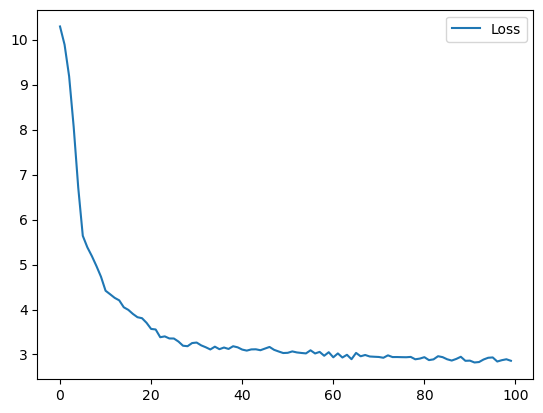

In [69]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

## Evaluation

In [70]:
# make a prediction
y_test_pred = model.predict(x_test)
# check length
y_test_pred.shape, y_test.shape

5/5 [==============================] - 0s 1000us/step


((140, 1), (140,))

In [71]:
evaluation = pd.DataFrame()
evaluation[['constructorRef', 'firstDriver', 'year', 'round']] = X_test.reset_index()[
    ['constructorRef', 'firstDriver', 'year', 'round']]
evaluation['prediction'] = [i[0] for i in y_test_pred]
evaluation['position'] = y_test

In [72]:
# Assuming 'evaluation' and 'data2223' are DataFrames, and 'date' is a common column
evaluation = pd.merge(evaluation, data2223[['constructorRef', 'firstDriver', 'year', 'round', 'driverRef']], 
         on=['constructorRef', 'firstDriver', 'year', 'round'], how='left')

In [73]:
# Rank the 'prediction' values within each 'round'
evaluation['positionPrediction'] = evaluation.groupby('round')['prediction'].rank(ascending=False)

# Transform ranks to positions (20 to 1)
evaluation['positionPrediction'] = 20 - evaluation['positionPrediction'] + 1

In [74]:
evaluation

,constructorRef,firstDriver,year,round,prediction,position,driverRef,positionPrediction
0,mercedes,1,2023.0,6.0,5.937190,4.0,hamilton,3.0
1,mercedes,1,2023.0,7.0,4.331350,2.0,hamilton,2.0
2,mercedes,1,2023.0,8.0,3.331438,3.0,hamilton,2.0
3,mercedes,1,2023.0,9.0,2.755981,8.0,hamilton,2.0
4,mercedes,1,2023.0,10.0,3.409270,3.0,hamilton,2.0
...,...,...,...,...,...,...,...,...
135,alphatauri,1,2023.0,8.0,16.013882,14.0,tsunoda,19.0
136,alphatauri,1,2023.0,9.0,17.143272,19.0,tsunoda,20.0
137,alphatauri,1,2023.0,10.0,16.163507,16.0,tsunoda,17.0
138,alphatauri,1,2023.0,11.0,18.991192,15.0,tsunoda,20.0


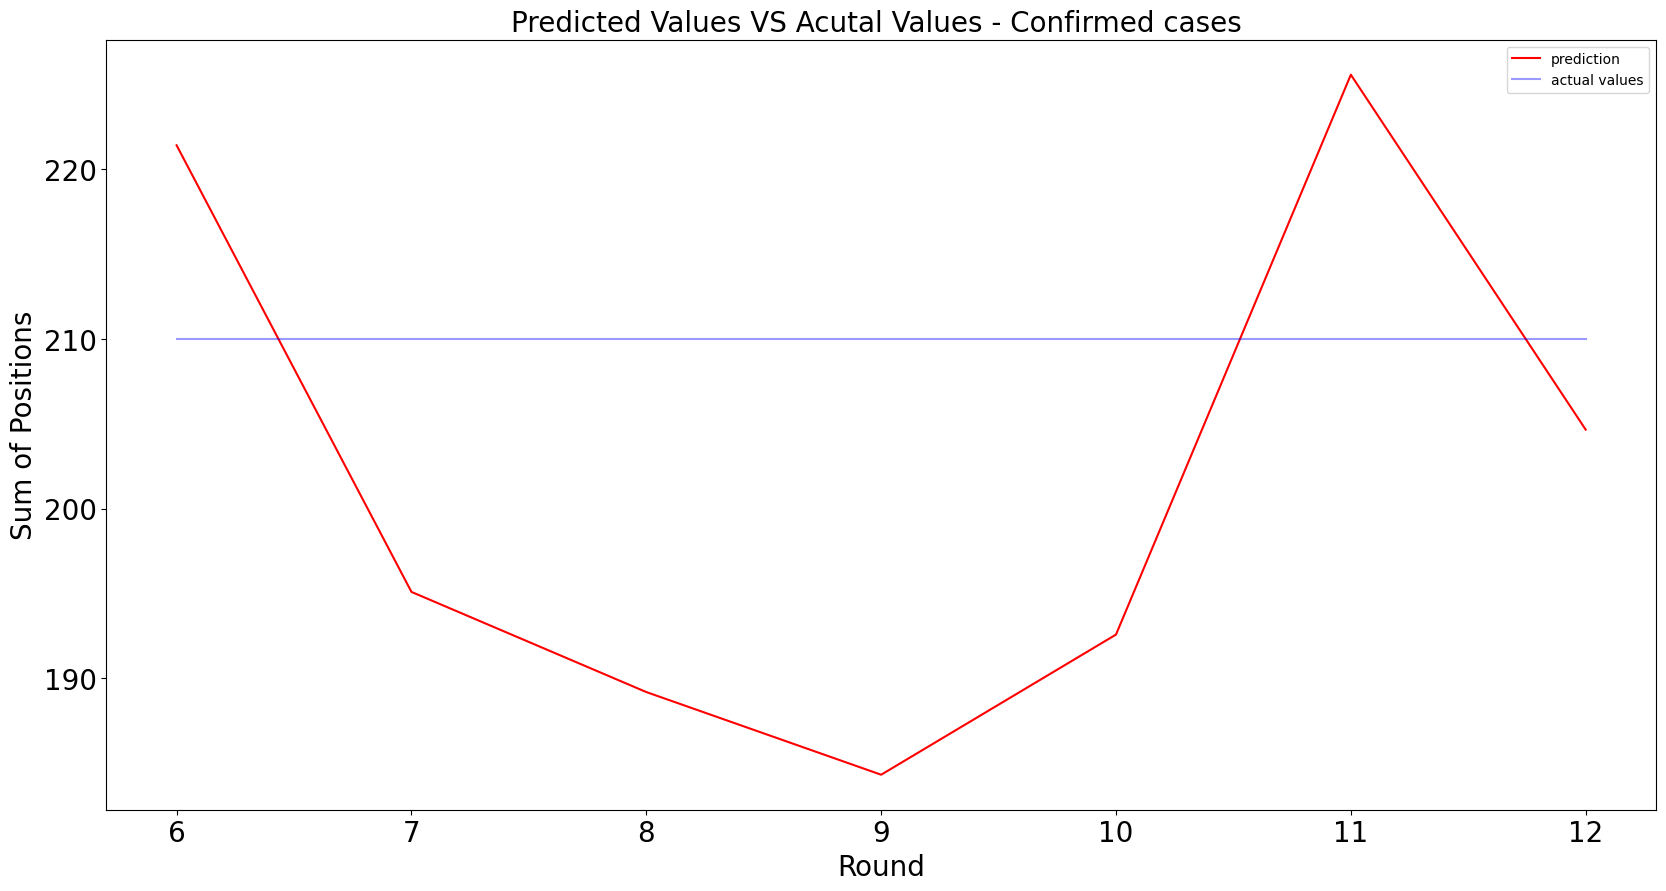

In [75]:
plt.figure(figsize=(20,10))
evaluation.groupby('round')['prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
evaluation.groupby('round')['position'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(size=20)
plt.yticks(size=20)

plt.ylabel('Sum of Positions',fontsize=20)
plt.xlabel('Round',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Confirmed cases ',fontsize=20)
plt.legend()

### Metrics

In [76]:
print('Real prediction:', mean_absolute_error(y_test, [i[0] for i in y_test_pred]))
print('Positional prediction:', mean_absolute_error(evaluation['position'], evaluation['positionPrediction']))

Real prediction: 2.6521833
Positional prediction: 2.642857142857143


In [77]:
print('Real prediction:', r2_score(y_test, [i[0] for i in y_test_pred]))
print('Positional prediction:', r2_score(evaluation['position'], evaluation['positionPrediction']))

Real prediction: 0.5807184670711996
Positional prediction: 0.5673469387755101
